#Lane Detection
Pipeline:
1. Grayscale Conversion
2. Gaussian Blur
3. Canny Edge Detection
4. Region of Interest
5. Hough Transform
6. Draw Lines


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


this image is : <class 'numpy.ndarray'> with dimension: (540, 960, 3)


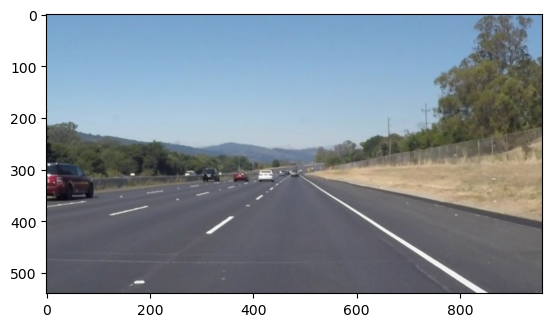

In [2]:
#reading in an image
image=mpimg.imread('E:/soumende1-Self-Driving-e4d4147/test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('this image is :', type(image),'with dimension:',image.shape)
plt.imshow(image)

In [3]:
import math

def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1, a2, b1, b2):
    da = a2 - a1
    db = b2 - b1
    dp = a1 - b1
    dap = perp(da)
    denom = np.dot(dap, db)
    num = np.dot(dap, dp)
    return (num / denom.astype(float)) * db + b1


def movingAverage(avg, new_sample, N=20):
    if (avg == 0):
        return new_sample
    avg -= avg / N;
    avg += new_sample / N;
    return avg;

# Grayscale Conversion
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Canny Edge Detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# Gaussian Blur
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Region of Interest
def region_of_interest(img, vertices):
    #defining a blank mask
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
           
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    # variables to keep track of most dominant segment
    largestLeftLineSize = 0
    largestRightLineSize = 0
    largestLeftLine = (0,0,0,0)
    largestRightLine = (0,0,0,0)
    
    global avgLeft
    global avgRight

    if lines is None:
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            size = math.hypot(x2 - x1, y2 - y1)
            slope = ((y2-y1)/(x2-x1))
            
            # find the most dominent segment based on length
            if (slope > 0.5): #right lane
                if (size > largestRightLineSize):
                    largestRightLine = (x1, y1, x2, y2)                    
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            elif (slope < -0.5): #left lane
                if (size > largestLeftLineSize):
                    largestLeftLine = (x1, y1, x2, y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # Define an imaginary horizontal line in the center of the screen
    # and at the bottom of the image, to extrapolate determined segment
    imgHeight, imgWidth = (img.shape[0], img.shape[1])
    upLinePoint1 = np.array( [0, int(imgHeight - (imgHeight/3))] )
    upLinePoint2 = np.array( [int(imgWidth), int(imgHeight - (imgHeight/3))] )
    downLinePoint1 = np.array( [0, int(imgHeight)] )
    downLinePoint2 = np.array( [int(imgWidth), int(imgHeight)] )
    
    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p3 = np.array( [largestLeftLine[0], largestLeftLine[1]] )
    p4 = np.array( [largestLeftLine[2], largestLeftLine[3]] )
    upLeftPoint = seg_intersect(upLinePoint1,upLinePoint2, p3,p4)
    downLeftPoint = seg_intersect(downLinePoint1,downLinePoint2, p3,p4)
    if (math.isnan(upLeftPoint[0]) or math.isnan(downLeftPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upLeftPoint[0]), int(upLeftPoint[1])), (int(downLeftPoint[0]), int(downLeftPoint[1])), [0, 0, 255], 8) #draw left line

    # Calculate the average position of detected left lane over multiple video frames and draw
    
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    avgLeft = (movingAverage(avgx1, upLeftPoint[0]), movingAverage(avgy1, upLeftPoint[1]), movingAverage(avgx2, downLeftPoint[0]), movingAverage(avgy2, downLeftPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line

    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p5 = np.array( [largestRightLine[0], largestRightLine[1]] )
    p6 = np.array( [largestRightLine[2], largestRightLine[3]] )
    upRightPoint = seg_intersect(upLinePoint1,upLinePoint2, p5,p6)
    downRightPoint = seg_intersect(downLinePoint1,downLinePoint2, p5,p6)
    if (math.isnan(upRightPoint[0]) or math.isnan(downRightPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upRightPoint[0]), int(upRightPoint[1])), (int(downRightPoint[0]), int(downRightPoint[1])), [0, 0, 255], 8) #draw left line

    # Calculate the average position of detected right lane over multiple video frames and draw
    
    avgx1, avgy1, avgx2, avgy2 = avgRight
    avgRight = (movingAverage(avgx1, upRightPoint[0]), movingAverage(avgy1, upRightPoint[1]), movingAverage(avgx2, downRightPoint[0]), movingAverage(avgy2, downRightPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgRight
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def process_image(image):

    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 11)
    

    edgesImage = canny(blurredImage, 40, 50)
    
    # mark out the trapezium region of interest

    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array( [[
                [3*width/4, 3*height/5],
                [width/4, 3*height/5],
                [40, height],
                [width - 40, height]
            ]], dtype=np.int32 )
    
   
    regionInterestImage = region_of_interest(edgesImage, vertices)
     
  
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 40, 30, 200)
    

    # draw output on top of original
    return weighted_img(lineMarkedImage, image)


# Test on Image

In [5]:
# import os 
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import numpy as np
# inDirectory="E:/soumende1-Self-Driving-e4d4147/test_images"
# outDirectory=inDirectory+"_out"
# if not os.path.exists(outDirectory):
#     os.makedirs(outDirectory)
# imageNames=os.listdir(inDirectory+"/")
# for imageName in imageNames:
#     avgLeft=(0,0,0,0)
#     avgRight=(0,0,0,0)
#     image=mpimg.imread(inDirectory+"/"+imageName)
#     out=process_image(image)
#     mpimg=imsave(outDirectory+"/"+imageName,out)
#     print("Processed"+outDirectory+"/"+imageName)
# print("processing complete")

In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Input and output directories
inDirectory = "E:/soumende1-Self-Driving-e4d4147/test_images"
outDirectory = inDirectory + "_out"

# Create output directory if it does not exist
if not os.path.exists(outDirectory):
    os.makedirs(outDirectory)

# List of valid image extensions
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Filter valid image files
imageNames = [f for f in os.listdir(inDirectory) if f.lower().endswith(valid_extensions)]

# Process each image
for imageName in imageNames:
    avgLeft = (0, 0, 0, 0)
    avgRight = (0, 0, 0, 0)

    # Read the image
    imagePath = os.path.join(inDirectory, imageName)
    image = mpimg.imread(imagePath)

    # Process the image (you need to define process_image function)
    out = process_image(image)

    # Save the processed image
    outPath = os.path.join(outDirectory, imageName)
    mpimg.imsave(outPath, out)

    print("Processed", outPath)

print("Processing complete.")


Processed E:/soumende1-Self-Driving-e4d4147/test_images_out\solidWhiteRight.jpg
Processed E:/soumende1-Self-Driving-e4d4147/test_images_out\solidYellowCurve.jpg
Processed E:/soumende1-Self-Driving-e4d4147/test_images_out\solidYellowCurve2.jpg
Processed E:/soumende1-Self-Driving-e4d4147/test_images_out\solidYellowLeft.jpg
Processed E:/soumende1-Self-Driving-e4d4147/test_images_out\whiteCarLaneSwitch.jpg
Processing complete.


## Plot a processed image



This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


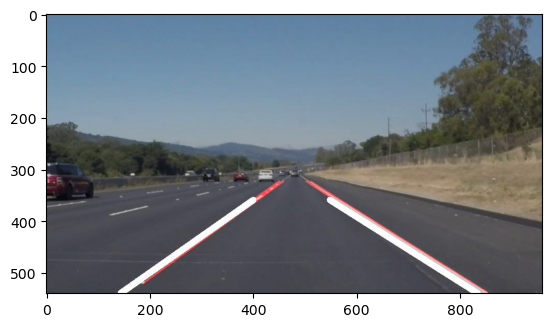

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


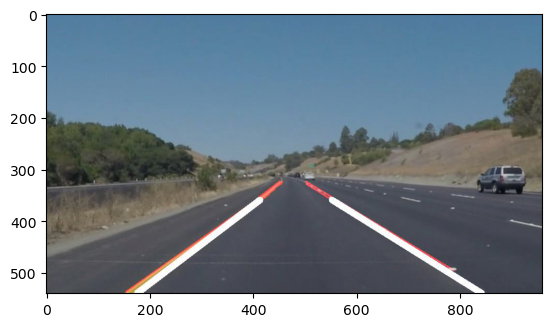

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


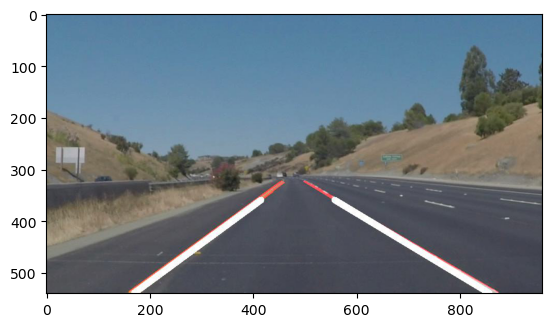

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


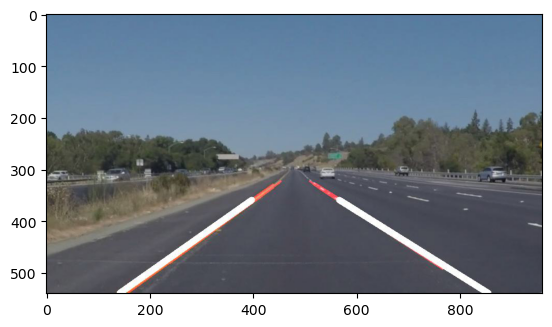

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


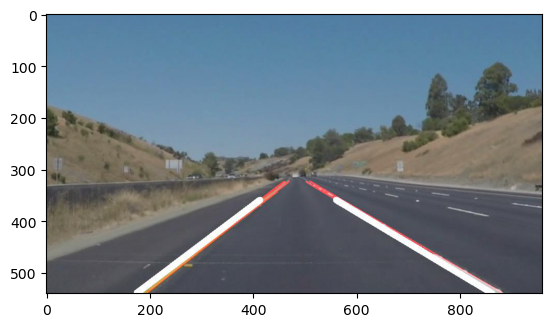

Processing complete


In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory containing the output images
outDirectory = "E:/soumende1-Self-Driving-e4d4147/test_images_out"

# List all valid image files in the output directory
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")  # Add supported extensions
imageNames = [f for f in os.listdir(outDirectory) if f.lower().endswith(valid_extensions)]

# Process each image
for imageName in imageNames:
    # Create the full file path
    imagePath = os.path.join(outDirectory, imageName)
    
    # Read the image
    image = mpimg.imread(imagePath)
    
    # Print image details
    print('This image is:', type(image), 'with dimensions:', image.shape)
    
    # Display the image
    plt.imshow(image)
    plt.show()

print("Processing complete")


In [8]:
!pip install imageio[ffmpeg]


In [9]:
!pip install moviepy


In [10]:
!pip install moviepy


In [11]:
pip show moviepy


Name: moviepy
Version: 2.1.1
Summary: Video editing with Python
Home-page: 
Author: Zulko 2024
Author-email: 
License: MIT License
Location: E:\anaconda3\Lib\site-packages
Requires: decorator, imageio, imageio_ffmpeg, numpy, pillow, proglog, python-dotenv
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [14]:
!pip list | findstr moviepy



moviepy                           2.1.1


In [15]:
import sys
print(sys.executable)  # Ensure this matches the environment where moviepy is installed


E:\anaconda3\python.exe


In [16]:
import moviepy
print(moviepy.__file__)


E:\anaconda3\Lib\site-packages\moviepy\__init__.py


In [20]:
import cv2
import os

# Path to the input video
input_video_path = "E:/soumende1-Self-Driving-e4d4147/video/solidWhiteRight.mp4"
output_video_path = "white.mp4"

# Check if input video exists
if not os.path.exists(input_video_path):
    raise FileNotFoundError(f"Input file not found: {input_video_path}")

# Open the video file
cap = cv2.VideoCapture(input_video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files

# Create VideoWriter object for the output video
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Break if no frame is read (end of video)

    # Apply the process_image function to the frame
    processed_frame = process_image(frame)

    # Write the processed frame to the output video
    out.write(processed_frame)

# Release resources
cap.release()
out.release()

print("Video processing complete.")


Video processing complete.


In [25]:
import cv2
import os
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

# Path to the input and output video
input_video_path = "E:/soumende1-Self-Driving-e4d4147/video/solidYellowLeft.mp4"
output_video_path = "gellow.mp4"

# Check if the input video exists
if not os.path.exists(input_video_path):
    raise FileNotFoundError(f"Input file not found: {input_video_path}")

# Open the video file
cap = cv2.VideoCapture(input_video_path)

# Validate if the video was successfully opened
if not cap.isOpened():
    raise IOError(f"Unable to open video file: {input_video_path}")

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Frame width
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Frame height
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files

# Create VideoWriter object for the output video
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Define the process_image function if not already defined
def process_image(frame):
    """
    Apply custom processing to the input frame.
    Example: Convert frame to grayscale.
    """
    # Convert the frame to grayscale (example processing)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Convert back to BGR for video writing (to match original frame dimensions)
    processed_frame = cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2BGR)
    
    return processed_frame

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("End of video reached or no frames available.")
        break  # Break the loop if no frame is read (end of video)

    try:
        # Apply the process_image function to the frame
        processed_frame = process_image(frame)

        # Ensure frame dimensions match the VideoWriter dimensions
        if processed_frame.shape[1] != frame_width or processed_frame.shape[0] != frame_height:
            processed_frame = cv2.resize(processed_frame, (frame_width, frame_height))

        # Write the processed frame to the output video
        out.write(processed_frame)
    except Exception as e:
        print(f"Error processing frame: {e}")
        break

# Release resources
cap.release()
out.release()

print("Video processing complete. Output saved to:", output_video_path)


End of video reached or no frames available.
Video processing complete. Output saved to: gellow.mp4


In [27]:
import cv2
import numpy as np
import os

# Path to the input and output video
input_video_path = "E:/soumende1-Self-Driving-e4d4147/video/solidYellowLeft.mp4"
output_video_path = "yellow_lane_detected.mp4"

# Check if the input video exists
if not os.path.exists(input_video_path):
    raise FileNotFoundError(f"Input file not found: {input_video_path}")

# Open the video file
cap = cv2.VideoCapture(input_video_path)

# Validate if the video was successfully opened
if not cap.isOpened():
    raise IOError(f"Unable to open video file: {input_video_path}")

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Frame width
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Frame height
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files

# Create VideoWriter object for the output video
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))


def region_of_interest(img, vertices):
    """
    Applies an image mask to keep only the region of interest.
    """
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=(255, 0, 0), thickness=10):
    """
    Draws lines on an image.
    """
    if lines is None:
        return
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def process_image(frame):
    """
    Detects lane lines in the frame and overlays them on the original frame.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Define region of interest (ROI)
    height, width = edges.shape
    roi_vertices = np.array([[
        (0, height),
        (width // 2 - 50, height // 2 + 50),
        (width // 2 + 50, height // 2 + 50),
        (width, height)
    ]], dtype=np.int32)
    cropped_edges = region_of_interest(edges, roi_vertices)

    # Perform Hough Transform to detect lines
    lines = cv2.HoughLinesP(
        cropped_edges,
        rho=1,
        theta=np.pi / 180,
        threshold=50,
        minLineLength=100,
        maxLineGap=50
    )

    # Create a blank image to draw lines
    line_image = np.zeros_like(frame)

    # Draw lines on the blank image
    draw_lines(line_image, lines)

    # Overlay the lines on the original frame
    processed_frame = cv2.addWeighted(frame, 0.8, line_image, 1, 0)

    return processed_frame


# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("End of video reached or no frames available.")
        break  # Break the loop if no frame is read (end of video)

    try:
        # Apply the process_image function to the frame
        processed_frame = process_image(frame)

        # Ensure frame dimensions match the VideoWriter dimensions
        if processed_frame.shape[1] != frame_width or processed_frame.shape[0] != frame_height:
            processed_frame = cv2.resize(processed_frame, (frame_width, frame_height))

        # Write the processed frame to the output video
        out.write(processed_frame)
    except Exception as e:
        print(f"Error processing frame: {e}")
        break

# Release resources
cap.release()
out.release()

print("Video processing complete. Output saved to:", output_video_path)


End of video reached or no frames available.
Video processing complete. Output saved to: yellow_lane_detected.mp4
